# Airbnb Price Recommender NYC

*Course: Machine Learning Projects with TensorFlow 2.0 by Vlad Sebastian Ionescu*

## 1. Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')

print(tf.__version__)

2.0.0


## 2. Load Data

In [2]:
data = pd.read_csv('data/airbnb_nyc.csv').sample(frac=1)
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
8670,6660373,Come to Know New York II,25812962,Claudio & Rose,Manhattan,East Harlem,40.79131,-73.94344,Private room,40,1,62,2019-07-05,1.35,3,257
25882,20686134,Hideaway Studio,14469743,Brian,Bronx,Pelham Bay,40.84711,-73.83039,Entire home/apt,80,2,66,2019-06-19,3.04,1,56
45628,34866737,amazing 3 BR 1 Bath in Hanover sq.,115771987,Yuki,Manhattan,Financial District,40.70750,-74.00853,Entire home/apt,196,30,0,NaN,NaN,6,222
6548,4746171,Modern 2BR Apartment in Heart of East Village,24450948,Peter,Manhattan,East Village,40.72649,-73.98284,Entire home/apt,250,2,11,2017-01-01,0.20,1,0
1623,739242,1 BR Modern Luxury Apart w W/D Steps From Park,15145088,Izi,Manhattan,Upper West Side,40.78747,-73.97238,Entire home/apt,185,30,8,2018-10-15,0.10,8,346


In [3]:
data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


## 3. Data Preprocessing

In [4]:
# Select the features that we think are most relevant
features = data[['neighbourhood_group', 'room_type', 'minimum_nights', 
                 'number_of_reviews',  'reviews_per_month',  
                 'calculated_host_listings_count',  'availability_365']]

In [5]:
# Check whether we have null values
features.isna().sum()

neighbourhood_group                   0
room_type                             0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [6]:
# Fill the null values with zero
features['reviews_per_month'] = features['reviews_per_month'].fillna(0)

In [7]:
# Transform categorical variables into one hot encoding variables
neighbourhood_group_onehot = pd.get_dummies(features['neighbourhood_group'])
room_type_onehot = pd.get_dummies(features['room_type'])

In [8]:
print(neighbourhood_group_onehot)

       Bronx  Brooklyn  Manhattan  Queens  Staten Island
8670       0         0          1       0              0
25882      1         0          0       0              0
45628      0         0          1       0              0
6548       0         0          1       0              0
1623       0         0          1       0              0
...      ...       ...        ...     ...            ...
20257      0         0          1       0              0
32353      0         0          0       1              0
39220      0         0          1       0              0
13339      0         0          1       0              0
17328      0         1          0       0              0

[48895 rows x 5 columns]


In [9]:
print(room_type_onehot)

       Entire home/apt  Private room  Shared room
8670                 0             1            0
25882                1             0            0
45628                1             0            0
6548                 1             0            0
1623                 1             0            0
...                ...           ...          ...
20257                0             1            0
32353                0             1            0
39220                0             1            0
13339                1             0            0
17328                0             1            0

[48895 rows x 3 columns]


In [10]:
features = features.drop(columns=['neighbourhood_group', 'room_type'])
features = pd.concat([features, neighbourhood_group_onehot, room_type_onehot], axis=1)
features.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room
8670,1,62,1.35,3,257,0,0,1,0,0,0,1,0
25882,2,66,3.04,1,56,1,0,0,0,0,1,0,0
45628,30,0,0.00,6,222,0,0,1,0,0,1,0,0
6548,2,11,0.20,1,0,0,0,1,0,0,1,0,0
1623,30,8,0.10,8,346,0,0,1,0,0,1,0,0


In [11]:
# Select the target variable
target = data['price']

In [12]:
# Train test split
train_size = int(0.7*len(data))
X_train, X_test = features.values[:train_size, :], features.values[train_size:, :]
y_train, y_test = target.values[:train_size], target.values[train_size:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(34226, 13)
(34226,)
(14669, 13)
(14669,)


## 4. Data Analysis

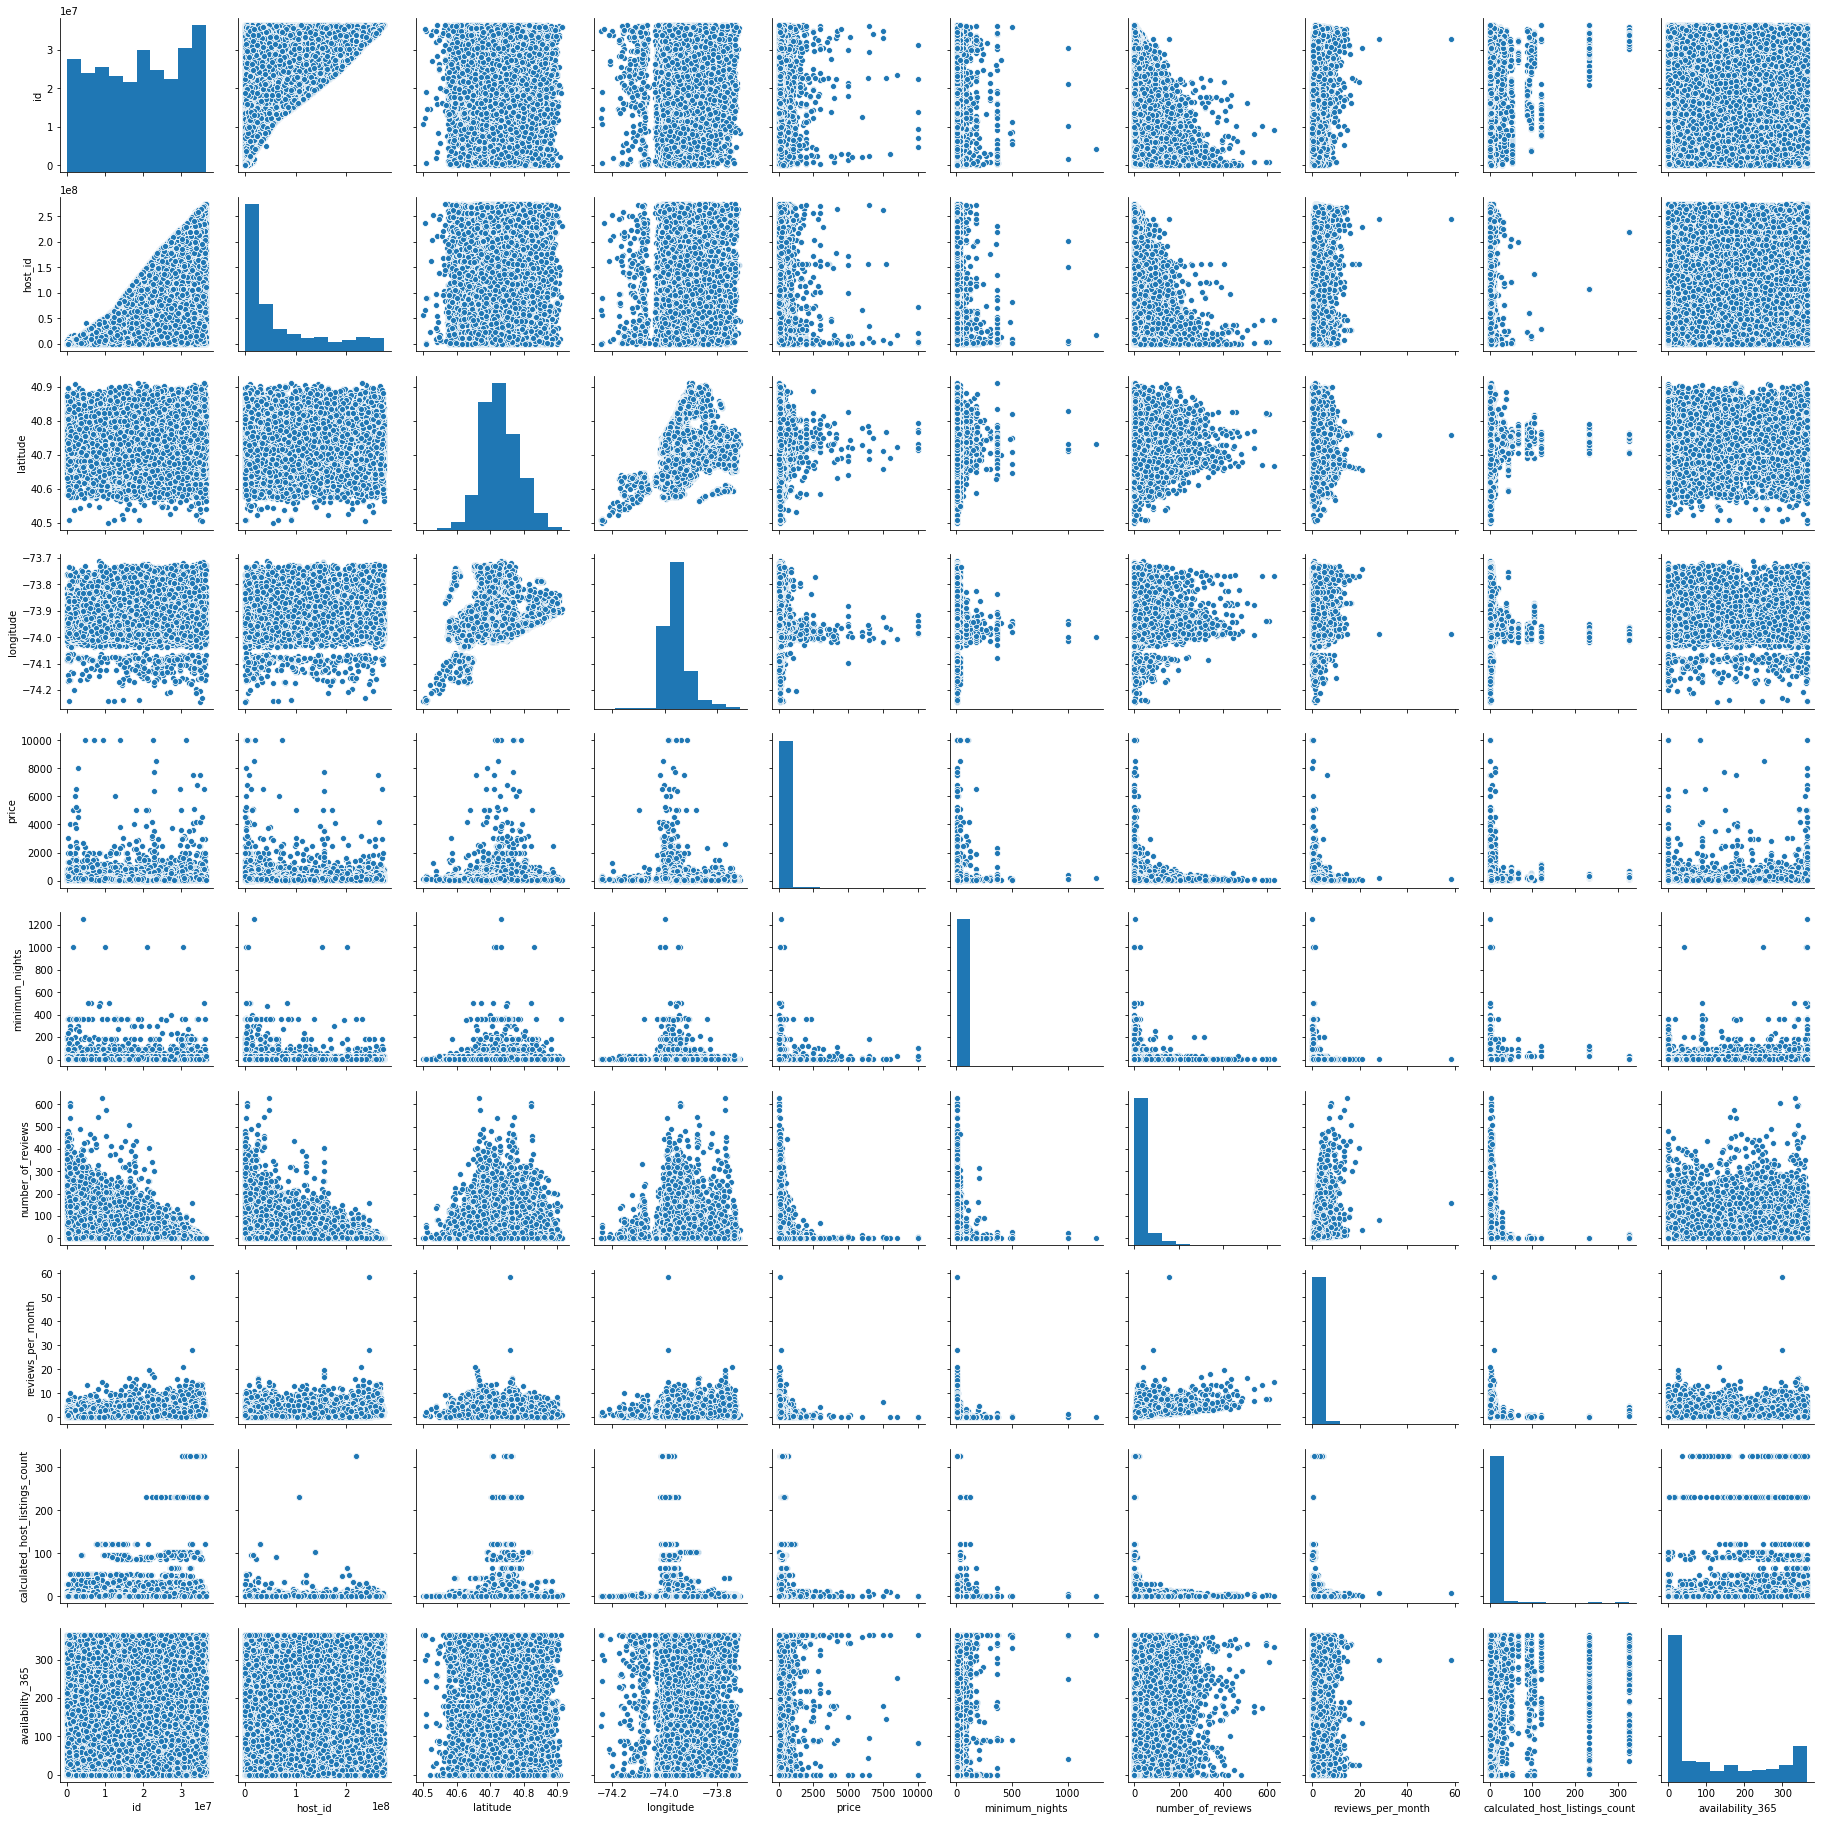

In [13]:
sns.pairplot(data)

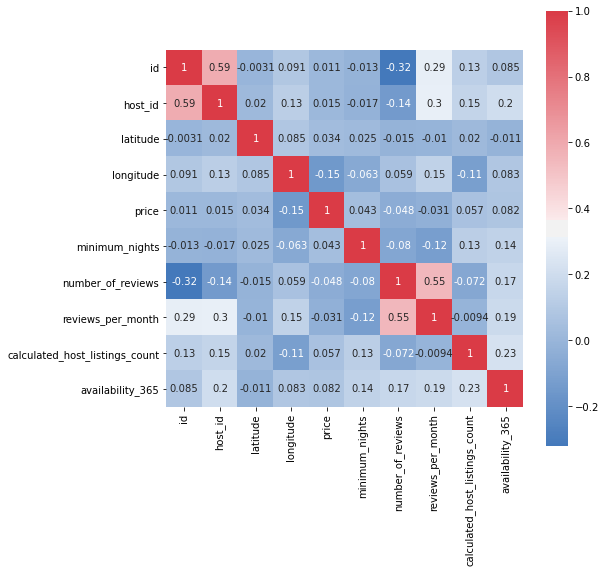

In [14]:
corr = data.corr()
cmap = sns.diverging_palette(250, 10, as_cmap=True)
plt.figure(figsize=(8, 8))
sns.heatmap(corr, square=True, cmap=cmap, annot=True)

## 5. TF MultiLayer Perceptron

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [16]:
def R_squared(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(y_true - y_pred))
    total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - residual/total
    return r2

In [17]:
adam_optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MAE

model.compile(
    optimizer=adam_optimizer,
    loss = loss_fn, 
    metrics=[tf.keras.metrics.MAE,
             tf.keras.metrics.MSE, 
             R_squared])

In [18]:
model.fit(X_train, y_train, epochs=15)
model.save('airbnb.h5')

Train on 34226 samples
Epoch 1/15
34226/34226 [==============================] - 6s 179us/sample - loss: 100.7875 - mean_absolute_error: 100.7874 - mean_squared_error: 66145.3203 - R_squared: -0.5792
Epoch 2/15
34226/34226 [==============================] - 5s 135us/sample - loss: 71.7922 - mean_absolute_error: 71.7922 - mean_squared_error: 57599.0781 - R_squared: 0.1071
Epoch 3/15
34226/34226 [==============================] - 4s 129us/sample - loss: 66.6778 - mean_absolute_error: 66.6778 - mean_squared_error: 55780.4062 - R_squared: 0.2179
Epoch 4/15
34226/34226 [==============================] - 5s 132us/sample - loss: 65.6551 - mean_absolute_error: 65.6551 - mean_squared_error: 55439.9023 - R_squared: 0.2407
Epoch 5/15
34226/34226 [==============================] - 4s 128us/sample - loss: 65.0862 - mean_absolute_error: 65.0862 - mean_squared_error: 55106.9570 - R_squared: 0.2490
Epoch 6/15
34226/34226 [==============================] - 4s 129us/sample - loss: 64.9149 - mean_absolut

In [21]:
loaded_model = tf.keras.models.load_model('airbnb.h5', custom_objects={'R_squared': R_squared})
print(loaded_model.summary())
model.evaluate(X_test, y_test, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  1792      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  129       
Total params: 1,921
Trainable params: 1,921
Non-trainable params: 0
_________________________________________________________________
None
14669/1 - 1s - loss: 52.8177 - mean_absolute_error: 62.4019 - mean_squared_error: 50601.3359 - R_squared: 0.2786


[62.40183430626898, 62.401882, 50601.336, 0.2786322]

In [27]:
print(loaded_model(X_test[:2]).numpy())
print(y_test[:2])

[[ 56.470787]
 [171.65244 ]]
[ 28 300]
